In [87]:
import sys  
sys.path.insert(0, './')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plt.style.use('seaborn-v0_8')
%matplotlib inline

In [88]:
# Filtered to just Bananas
df = pd.read_csv('../round3/data/prices_round_3_day_1.csv', index_col='timestamp', delimiter=';')
df = df.loc[df['product']=='BERRIES']
df = df[['mid_price']].rename(columns={'mid_price': 'Value'})
df.head()

,Value
timestamp,
0,3919.5
100,3919.5
200,3919.5
300,3919.5
400,3920.5


In [89]:

def difference(x, d=1):
    return np.diff(x, d)

def undo_difference(x, x_diff):
    return np.concatenate(([x[0]], x_diff)).cumsum()

In [90]:
def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)

  train_size = (int)(0.8 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # df_train_2[['Value','Predicted_Values']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # df_test[['Value','Predicted_Values']].plot()

  RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,theta,intercept,RMSE]

In [91]:
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.8 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]

In [92]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

In [93]:
# df_testing = pd.DataFrame(difference(df.Value), columns=['Value'])
df_testing = pd.DataFrame(np.log(df.Value).diff().diff(12))
# adf_check(df_testing.Value.dropna())

result = adfuller(df_testing.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -26.129080
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


<Axes: xlabel='timestamp'>

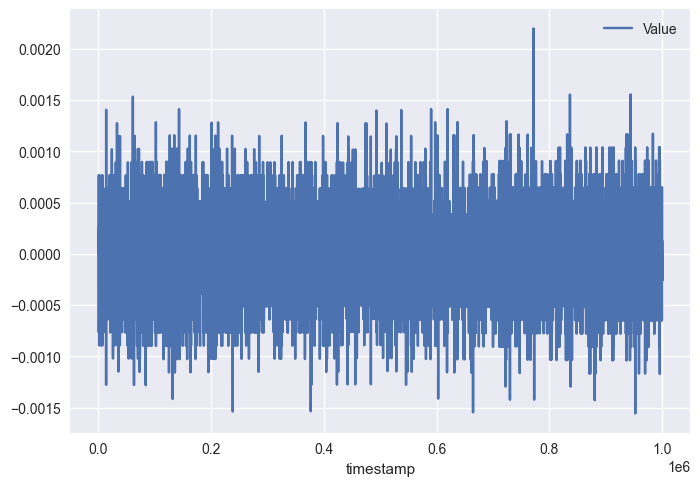

In [94]:
df_testing.plot()

c:\Users\redce\Documents\cs-stuff\imc-2023\.venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


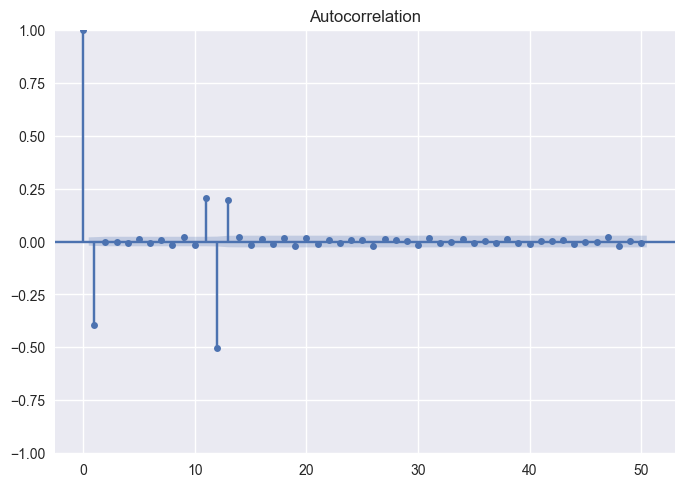

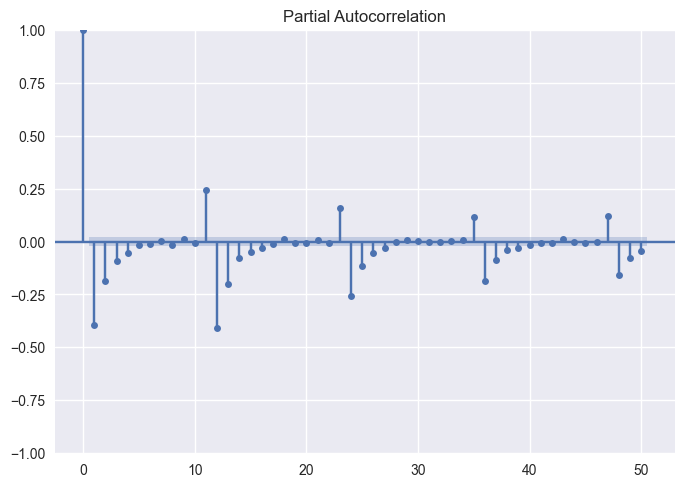

In [95]:
ACF = plot_acf(df_testing.dropna(),lags=50)
PACF = plot_pacf(df_testing.dropna(),lags=50)

In [96]:
best_RMSE=100000000000
best_p = -1
for i in range(1,21):
  [df_train,df_test,theta,intercept,RMSE] = AR(i,pd.DataFrame(df_testing.Value))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_p = i
  
print(best_p)

The RMSE is : 0.00035404917376395505 , Value of p :  1
The RMSE is : 0.00034735489278816807 , Value of p :  2
The RMSE is : 0.0003463575205028417 , Value of p :  3
The RMSE is : 0.0003458949013924685 , Value of p :  4
The RMSE is : 0.00034577206509189785 , Value of p :  5
The RMSE is : 0.0003457223576154848 , Value of p :  6
The RMSE is : 0.00034571760639692556 , Value of p :  7
The RMSE is : 0.0003456259877369666 , Value of p :  8
The RMSE is : 0.0003456313587218773 , Value of p :  9
The RMSE is : 0.0003456032740590875 , Value of p :  10
The RMSE is : 0.00033280132235333367 , Value of p :  11
The RMSE is : 0.0003058913546453469 , Value of p :  12
The RMSE is : 0.0002989237783887186 , Value of p :  13
The RMSE is : 0.000297257633836351 , Value of p :  14
The RMSE is : 0.000297737036158771 , Value of p :  15
The RMSE is : 0.00029738664560154907 , Value of p :  16
The RMSE is : 0.00029733129034386393 , Value of p :  17
The RMSE is : 0.00029731033164291513 , Value of p :  18
The RMSE is :

C:\Users\redce\AppData\Local\Temp\ipykernel_17080\3076771838.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\redce\AppData\Local\Temp\ipykernel_17080\3076771838.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\redce\AppData\Local\Temp\ipykernel_17080\3076771838.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [97]:
[df_train,df_test,theta,intercept,RMSE] = AR(best_p,pd.DataFrame(df_testing.Value))

The RMSE is : 0.000297257633836351 , Value of p :  14


C:\Users\redce\AppData\Local\Temp\ipykernel_17080\3076771838.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


<Axes: xlabel='timestamp'>

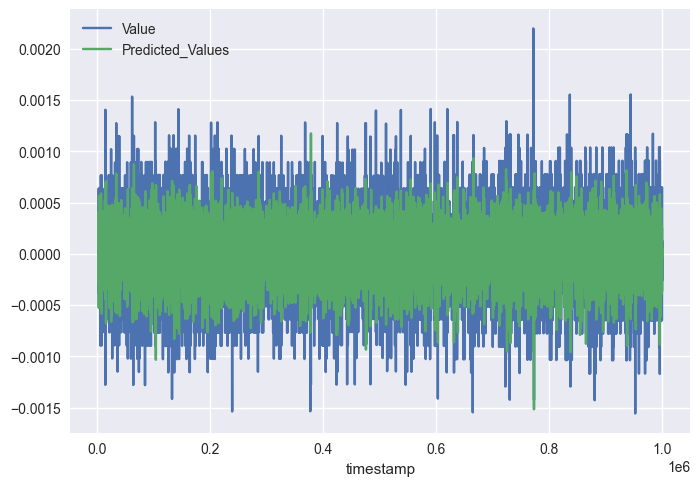

In [98]:
df_c = pd.concat([df_train,df_test])
df_c[['Value','Predicted_Values']].plot()

In [99]:
res = pd.DataFrame()
res['Residuals'] = df_c.Value - df_c.Predicted_Values

In [100]:
res

,Residuals
timestamp,
2700,-0.000046
2800,-0.000159
2900,0.000258
3000,0.000145
3100,0.000065
...,...
999500,0.000107
999600,-0.000232
999700,-0.000106


<Axes: ylabel='Density'>

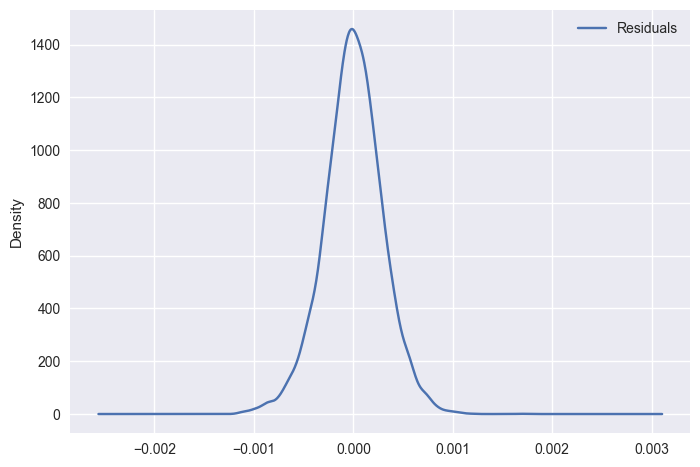

In [101]:
res.plot(kind='kde')

C:\Users\redce\AppData\Local\Temp\ipykernel_17080\1694941029.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\redce\AppData\Local\Temp\ipykernel_17080\1694941029.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\redce\AppData\Local\Temp\ipykernel_17080\1694941029.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

The RMSE is : 0.00029687284912843814 , Value of q :  1
The RMSE is : 0.0002968736020229111 , Value of q :  2
The RMSE is : 0.00029701228230057255 , Value of q :  3
The RMSE is : 0.00029717197572325517 , Value of q :  4
The RMSE is : 0.0002971877786166726 , Value of q :  5
The RMSE is : 0.00029720261059727846 , Value of q :  6
The RMSE is : 0.00029718742036498216 , Value of q :  7
The RMSE is : 0.00029719844990344223 , Value of q :  8
The RMSE is : 0.0002971028894024061 , Value of q :  9
The RMSE is : 0.00029707027088503497 , Value of q :  10
The RMSE is : 0.00029705352779947413 , Value of q :  11


C:\Users\redce\AppData\Local\Temp\ipykernel_17080\1694941029.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\redce\AppData\Local\Temp\ipykernel_17080\1694941029.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\redce\AppData\Local\Temp\ipykernel_17080\1694941029.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

The RMSE is : 0.0002926210691692208 , Value of q :  12
12


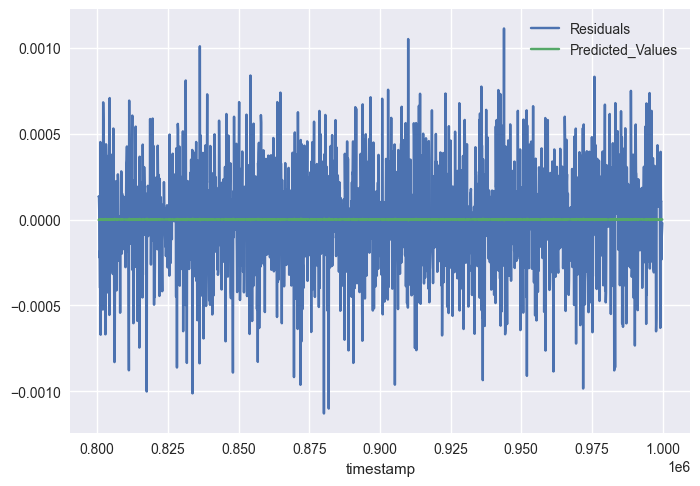

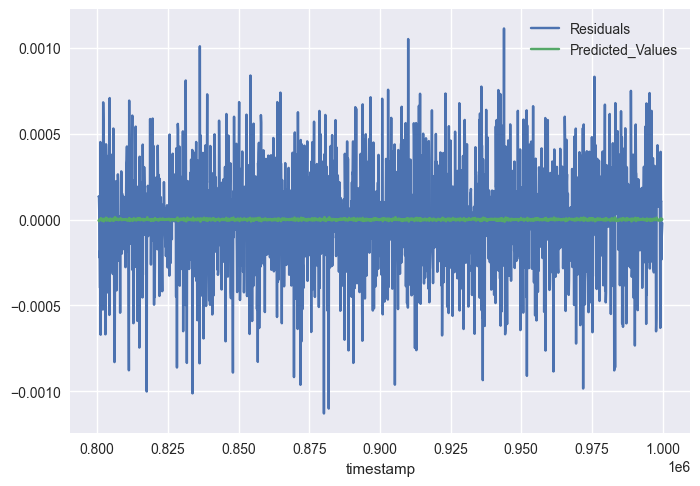

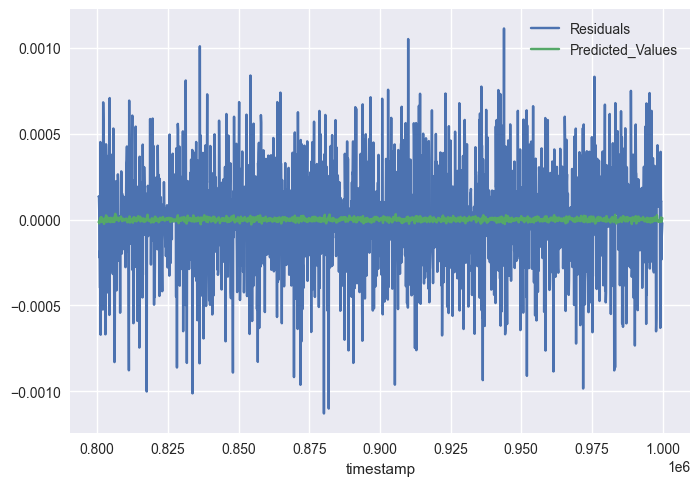

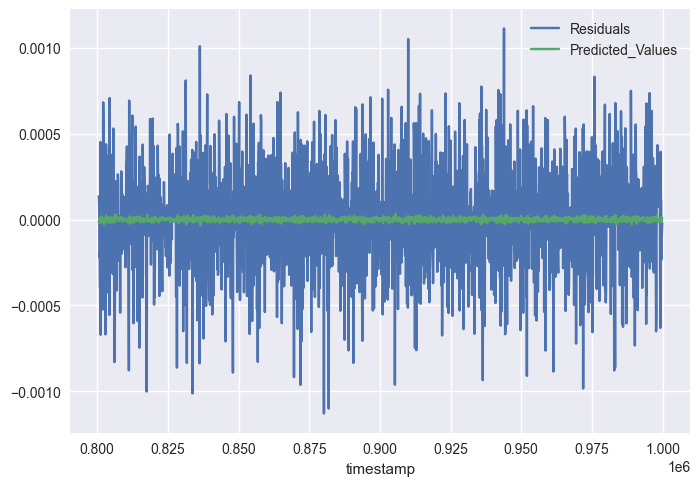

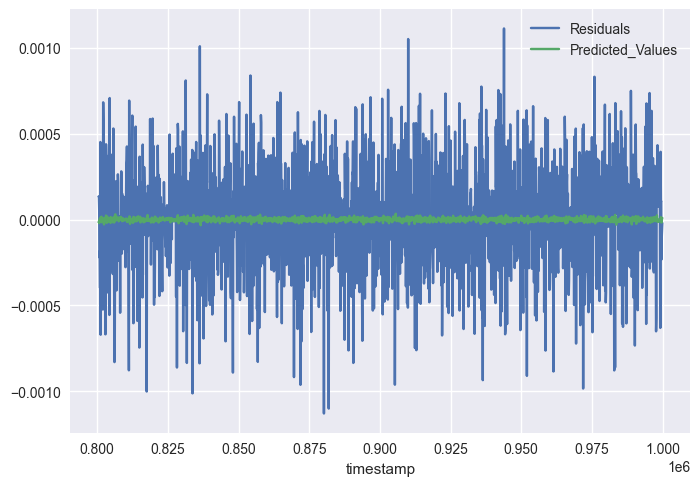

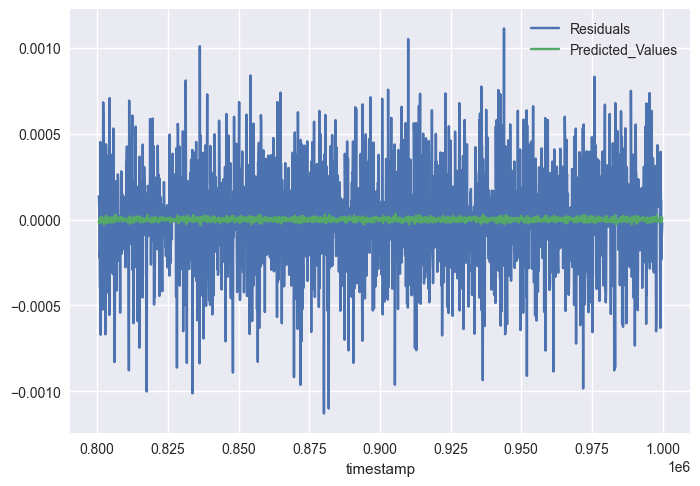

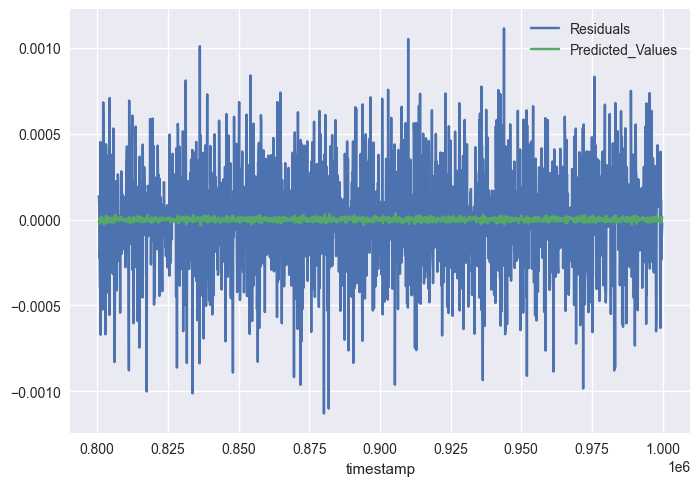

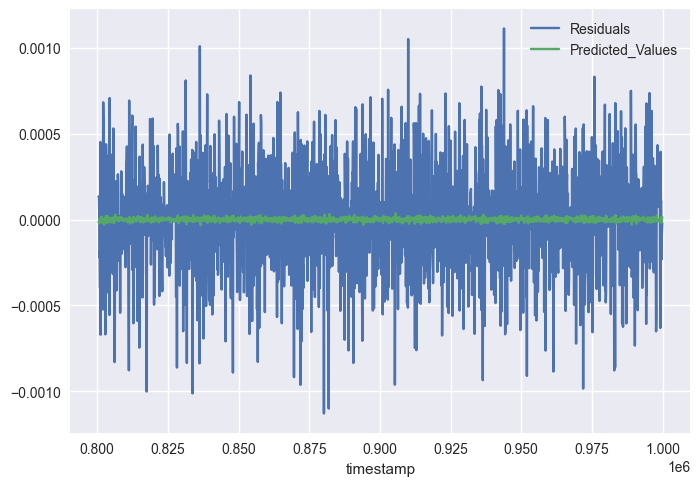

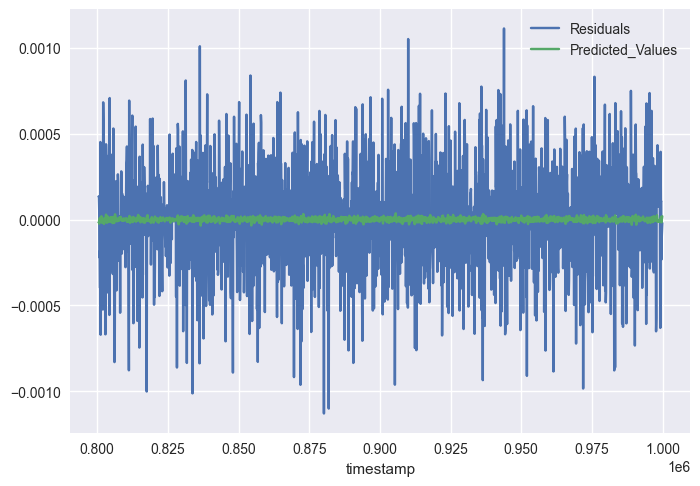

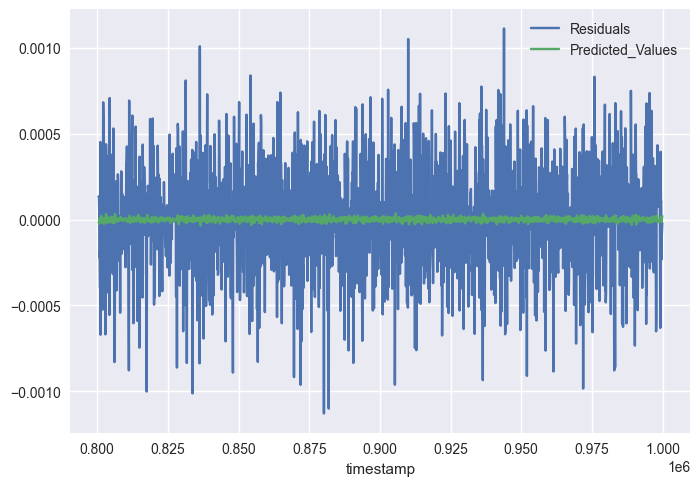

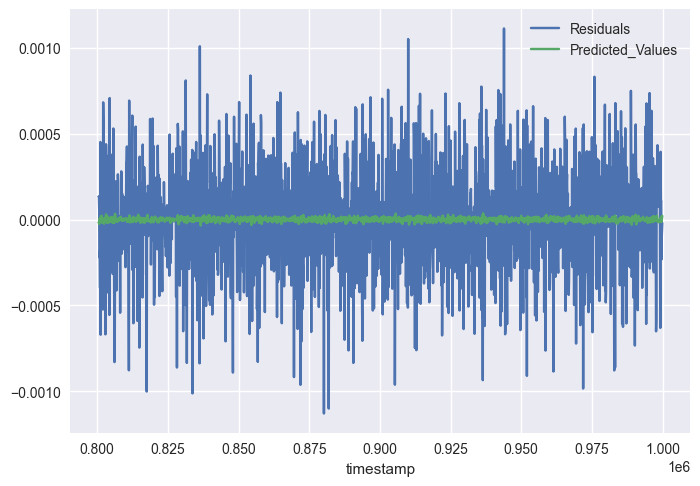

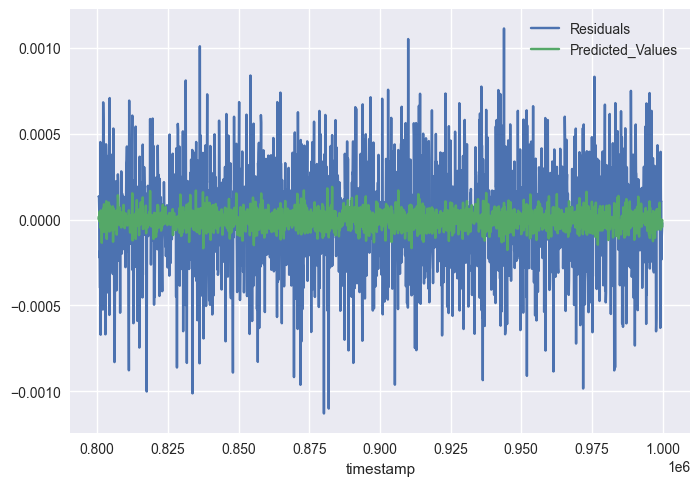

In [102]:
best_RMSE=100000000000
best_q = -1

for i in range(1,13):
  [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_q = i
  
print(best_q)

C:\Users\redce\AppData\Local\Temp\ipykernel_17080\1694941029.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


The RMSE is : 0.0002926210691692208 , Value of q :  12
[[-0.00396987]
 [-0.01191792]
 [-0.02545048]
 [ 0.00766225]
 [ 0.00104134]
 [ 0.00331578]
 [-0.00701088]
 [ 0.00252779]
 [ 0.00724647]
 [ 0.00266472]
 [ 0.00303916]
 [-0.16809525]]
[1.80428041e-07]


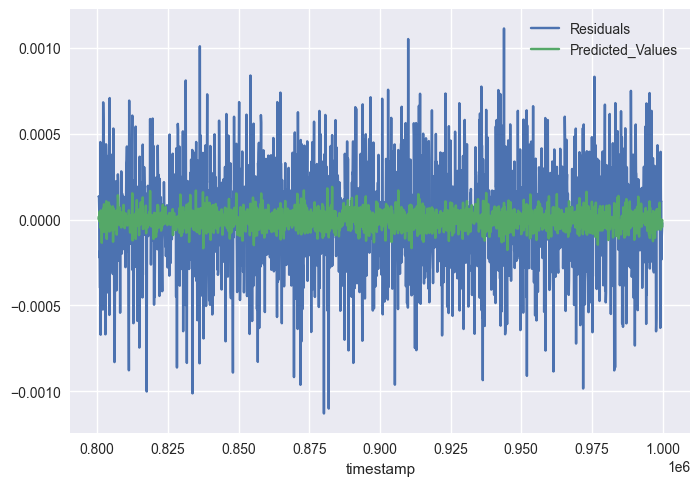

In [103]:
[res_train,res_test,theta,intercept,RMSE] = MA(best_q,pd.DataFrame(res.Residuals))
print(theta)
print(intercept)

In [104]:
res_c = pd.concat([res_train,res_test])

In [105]:
res_c

,Residuals,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Shifted_values_11,Shifted_values_12,Predicted_Values
timestamp,,,,,,,,,,,,,,
3900,-0.000143,0.000215,0.000218,-0.000105,0.000033,-0.000310,-0.000214,-0.000132,0.000065,0.000145,0.000258,-0.000159,-0.000046,8.726779e-06
4000,0.000318,-0.000143,0.000215,0.000218,-0.000105,0.000033,-0.000310,-0.000214,-0.000132,0.000065,0.000145,0.000258,-0.000159,2.037600e-05
4100,0.000216,0.000318,-0.000143,0.000215,0.000218,-0.000105,0.000033,-0.000310,-0.000214,-0.000132,0.000065,0.000145,0.000258,-4.520253e-05
4200,-0.000357,0.000216,0.000318,-0.000143,0.000215,0.000218,-0.000105,0.000033,-0.000310,-0.000214,-0.000132,0.000065,0.000145,-2.630154e-05
4300,0.000103,-0.000357,0.000216,0.000318,-0.000143,0.000215,0.000218,-0.000105,0.000033,-0.000310,-0.000214,-0.000132,0.000065,-2.259906e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999500,0.000107,0.000103,0.000394,-0.000631,-0.000135,0.000341,0.000270,0.000179,0.000130,0.000291,0.000077,0.000174,0.000076,5.126098e-07
999600,-0.000232,0.000107,0.000103,0.000394,-0.000631,-0.000135,0.000341,0.000270,0.000179,0.000130,0.000291,0.000077,0.000174,-4.401990e-05
999700,-0.000106,-0.000232,0.000107,0.000103,0.000394,-0.000631,-0.000135,0.000341,0.000270,0.000179,0.000130,0.000291,0.000077,-1.302914e-05


In [106]:
df_c.Predicted_Values += res_c.Predicted_Values

<Axes: xlabel='timestamp'>

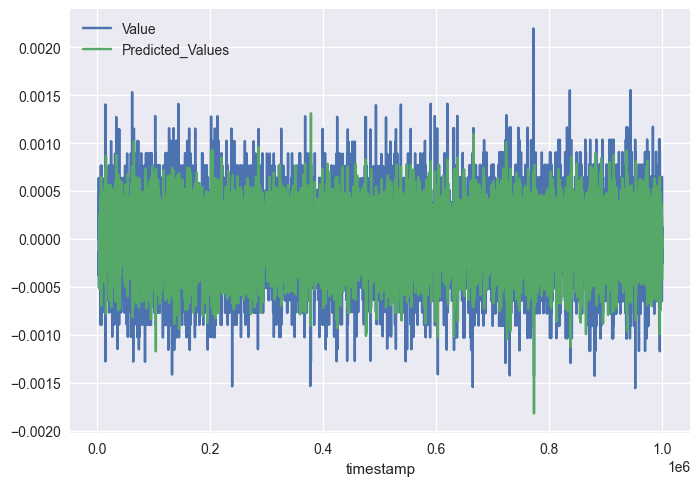

In [107]:
df_c[['Value','Predicted_Values']].plot()

In [108]:
df_c.Value += np.log(df).shift(1).Value
df_c.Value += np.log(df).diff().shift(12).Value
df_c.Predicted_Values += np.log(df).shift(1).Value
df_c.Predicted_Values += np.log(df).diff().shift(12).Value
df_c.Value = np.exp(df_c.Value)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)

In [109]:
df_c

,Value,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Shifted_values_11,Shifted_values_12,Shifted_values_13,Shifted_values_14,Predicted_Values
timestamp,,,,,,,,,,,,,,,,
2700,3918.5,-0.000255,0.000000,0.000255,0.000383,-0.000893,0.000766,0.000000,0.000128,0.000766,-0.000638,-7.655014e-04,0.000000e+00,2.551671e-04,0.000000e+00,NaN
2800,3917.5,0.000000,-0.000255,0.000000,0.000255,0.000383,-0.000893,0.000766,0.000000,0.000128,0.000766,-6.383658e-04,-7.655014e-04,0.000000e+00,2.551671e-04,NaN
2900,3917.5,0.000255,0.000000,-0.000255,0.000000,0.000255,0.000383,-0.000893,0.000766,0.000000,0.000128,7.659087e-04,-6.383658e-04,-7.655014e-04,0.000000e+00,NaN
3000,3918.5,0.000638,0.000255,0.000000,-0.000255,0.000000,0.000255,0.000383,-0.000893,0.000766,0.000000,1.275592e-04,7.659087e-04,-6.383658e-04,-7.655014e-04,NaN
3100,3918.0,-0.000383,0.000638,0.000255,0.000000,-0.000255,0.000000,0.000255,0.000383,-0.000893,0.000766,0.000000e+00,1.275592e-04,7.659087e-04,-6.383658e-04,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999500,3850.0,-0.000260,0.000650,-0.000650,-0.000520,0.000260,0.000520,0.000260,0.000000,0.000000,0.000260,-6.758784e-08,-1.300306e-04,3.900410e-04,1.300137e-04,3849.590845
999600,3850.0,0.000130,-0.000260,0.000650,-0.000650,-0.000520,0.000260,0.000520,0.000260,0.000000,0.000000,2.598753e-04,-6.758784e-08,-1.300306e-04,3.900410e-04,3850.725651
999700,3850.5,-0.000260,0.000130,-0.000260,0.000650,-0.000650,-0.000520,0.000260,0.000520,0.000260,0.000000,0.000000e+00,2.598753e-04,-6.758784e-08,-1.300306e-04,3850.859916


<Axes: xlabel='timestamp'>

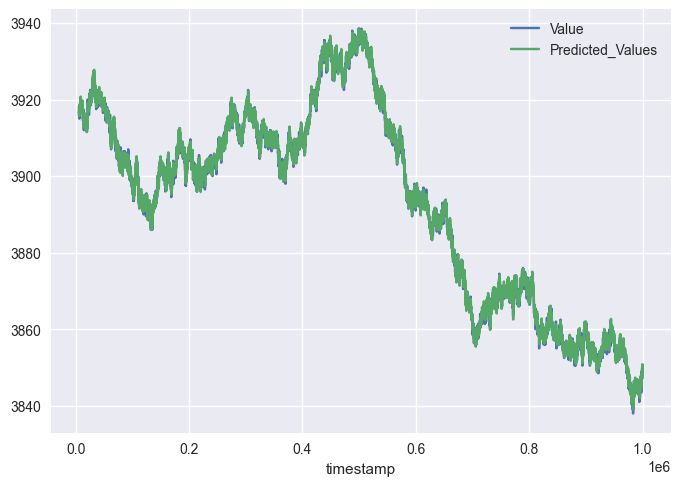

In [110]:
df_c.iloc[30:,:][['Value','Predicted_Values']].plot()